#### The following code and solutions are submitted by Heather Passmore for the Ultimate Take-Home coding challange for Springboard Data Science Career Track.

## Part 1 - Exploratory Data Analysis
#### The attached logins.json file contains (simulated) timestamps of user logins in a particular geographic location. Aggregate these login counts based on 15-minute time intervals, and visualize and describe the resulting time series of login counts in ways that best characterize the underlying patterns of the demand. Please report/illustrate important features of the demand, such as daily cycles. If there are data quality issues, please report them.

In [1]:
# Import modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import tree
import pickle
import scipy.stats
from scipy.stats import norm
import scipy as sp
from datetime import datetime as dt
import json

# Figures inline, visualization style
%matplotlib inline

# Setup Seaborn
sns.set_style("whitegrid")
sns.set_context("talk")

In [2]:
# Read logins.json, create empty list 'logins', 
file = 'logins.json'
json_data = json.loads(open(file).read())
logins = []
for n in range(1, len(json_data['login_time'])):
    logins.append(json_data['login_time'][n])
    
# create dataframe from 'logins': df
df = pd.DataFrame(logins)
df.head()

,0
0,1970-01-01 20:16:10
1,1970-01-01 20:16:37
2,1970-01-01 20:16:36
3,1970-01-01 20:26:21
4,1970-01-01 20:21:41


In [3]:
# Copy logins string and format as datetime: times
df['times'] = df[0:]
df['times'] = df['times'].apply(lambda d: dt.strptime(d, '%Y-%m-%d %H:%M:%S'))

# Create login counter to add up over 15 minute periods: 'counter'
df['counter'] = 1

In [4]:
# set the index to 'times' column
df = df.set_index('times')

In [5]:
# create new dataframe with timestamp index and counter column
df2 = pd.DataFrame(df['counter'])
df2.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 93141 entries, 1970-01-01 20:16:10 to 1970-04-13 18:54:23
Data columns (total 1 columns):
counter    93141 non-null int64
dtypes: int64(1)
memory usage: 1.4 MB


In [6]:
# use resample to sum counter column into 15-minute bins
sample = pd.DataFrame(df2.counter.resample('15T').sum())
sample.head()

,counter
times,
1970-01-01 20:00:00,1
1970-01-01 20:15:00,6
1970-01-01 20:30:00,9
1970-01-01 20:45:00,7
1970-01-01 21:00:00,1


In [7]:
# check counter data
sample.describe()

,counter
count,9788.000000
mean,9.515836
std,8.328917
min,0.000000
25%,3.000000
50%,7.000000
75%,13.000000
max,73.000000


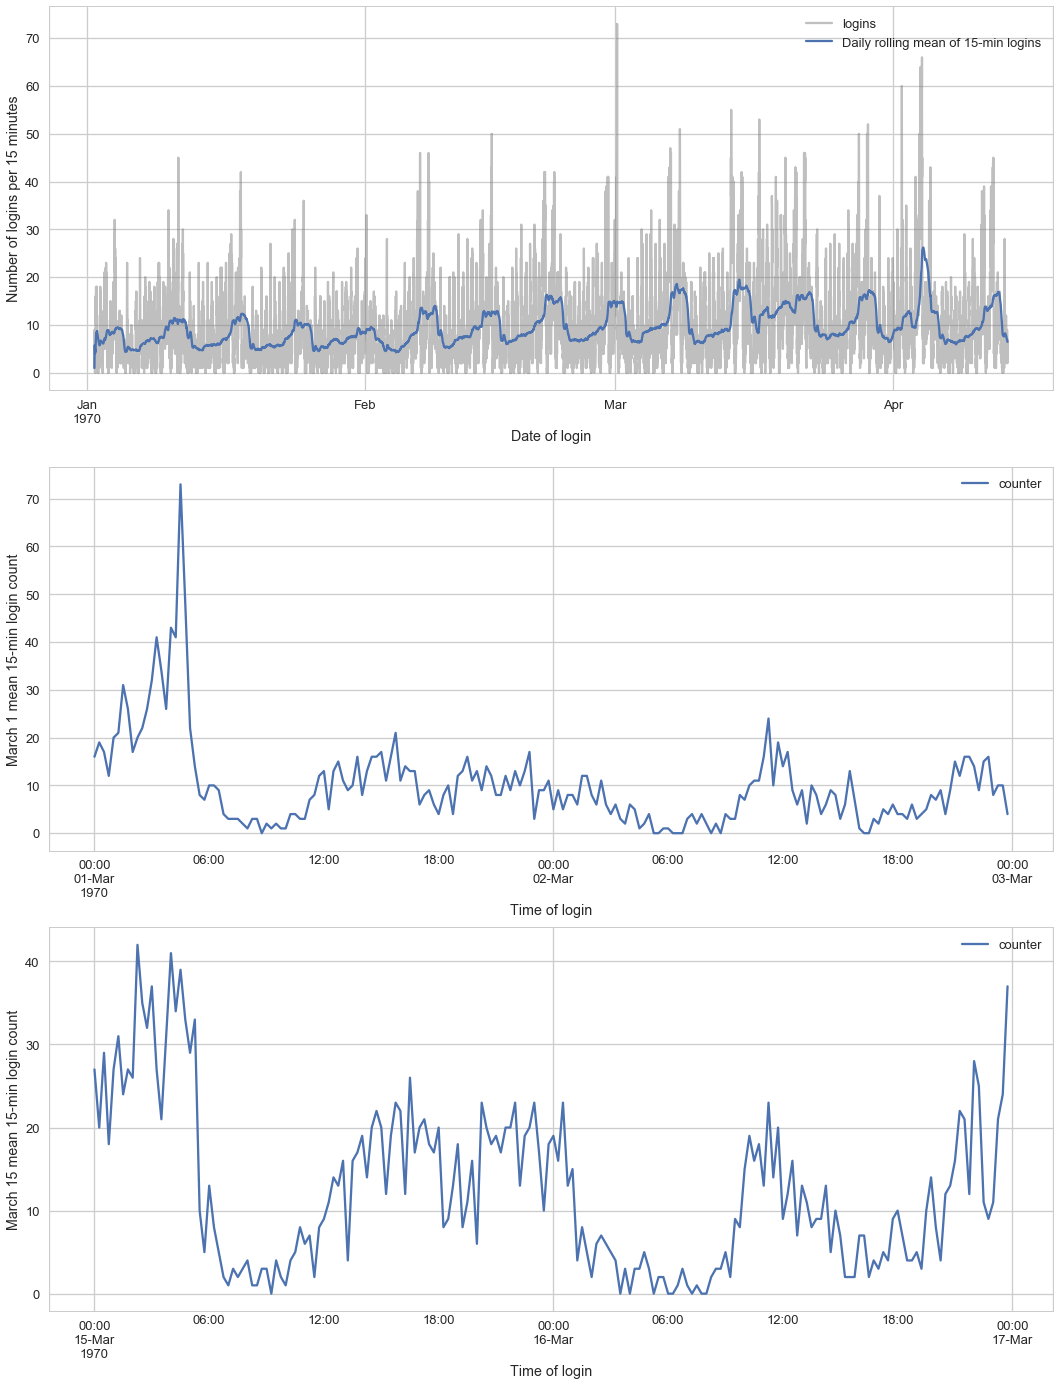

In [8]:
fig, axes = plt.subplots(3,1)
fig.set_size_inches(18,24)
sample.counter.plot(ax=axes[0], alpha=0.5, c='grey', label='logins')
sample.counter.rolling('d').mean().plot(ax=axes[0], label='Daily rolling mean of 15-min logins')
sample.loc['1970-03-01':'1970-03-02'].plot(ax=axes[1], label='mean logins')
sample.loc['1970-03-15':'1970-03-16'].plot(ax=axes[2], label='mean logins')
axes[0].legend()
axes[0].set_ylabel('Number of logins per 15 minutes')
axes[1].set_ylabel('March 1 mean 15-min login count')
axes[2].set_ylabel('March 15 mean 15-min login count')
axes[0].set_xlabel('Date of login')
axes[1].set_xlabel('Time of login')
axes[2].set_xlabel('Time of login')

In [9]:
# create hour-of-day and day_of_week features
sample['hour_of_day'] = sample.index.hour
sample['day_of_week'] = sample.index.weekday

In [10]:
#Define a generic function using Pandas replace function
def coding(col, codeDict):
  colCoded = pd.Series(col, copy=True)
  for key, value in codeDict.items():
    colCoded.replace(key, value, inplace=True)
  return colCoded

In [11]:
# assign hour_of_day into True/False for 'night' where True = night
print('Before Coding:')
print(pd.value_counts(sample['hour_of_day']))
sample['night'] = coding(sample['hour_of_day'], {0:1, 1:1, 2:1, 3:1, 4:1, 5:1, 6:0,
                                    7:0, 8:0, 9:0, 10:0, 11:0, 12:0, 13:0, 14:0, 15:0, 16:0,
                                    17:0, 18:1, 19:1, 20:1, 21:1, 22:1, 23:1})
print('\nAfter Coding:')
print(pd.value_counts(sample['night']))

Before Coding:
23    408
15    408
8     408
16    408
1     408
9     408
17    408
2     408
10    408
18    408
3     408
11    408
0     408
4     408
12    408
20    408
5     408
13    408
21    408
6     408
14    408
22    408
7     408
19    404
Name: hour_of_day, dtype: int64

After Coding:
0    4896
1    4892
Name: night, dtype: int64


In [12]:
sample.head()

,counter,hour_of_day,day_of_week,night
times,,,,
1970-01-01 20:00:00,1,20,3,1
1970-01-01 20:15:00,6,20,3,1
1970-01-01 20:30:00,9,20,3,1
1970-01-01 20:45:00,7,20,3,1
1970-01-01 21:00:00,1,21,3,1


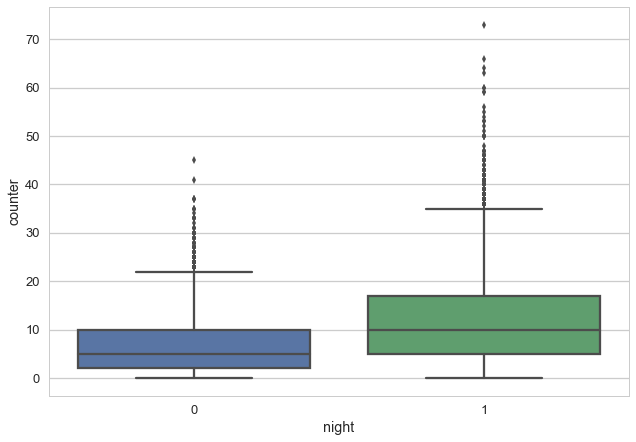

In [13]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Use boxplot to see mean counter differs between night and day 1= night, 0= day
sns.boxplot(x="night", y="counter",  data=sample);

In [14]:
# Encode day_of_week (Monday=0, Sunday = 6) => weekday(1)/weekend(0) 
print('Before Coding:')
print(pd.value_counts(sample['day_of_week']))
sample['weekday'] = coding(sample['day_of_week'], {0:1,1:1,2:1,3:1,4:1,5:0,6:0})
print('\nAfter Coding:')
print(pd.value_counts(sample['weekday']))

Before Coding:
6    1440
5    1440
4    1440
0    1420
3    1360
2    1344
1    1344
Name: day_of_week, dtype: int64

After Coding:
1    6908
0    2880
Name: weekday, dtype: int64


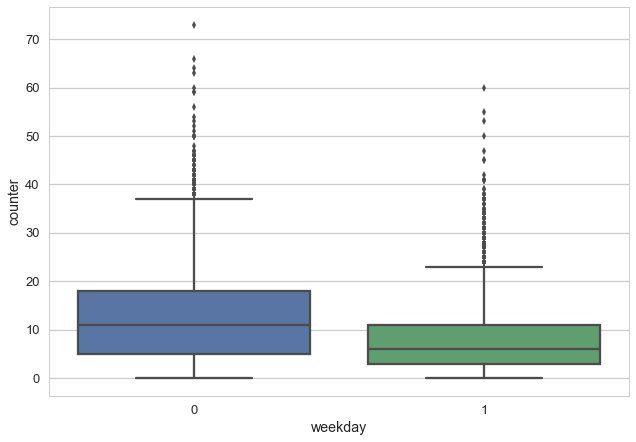

In [15]:
# Use boxplot to see mean counter differs between night and day 1= night, 0= day
sns.boxplot(x="weekday", y="counter",  data=sample);

#### Summary of findings: 
1. Patterns of demand based on logins binned in 15-minute intervals appear to peak daily as well as 4 to 5 times per month. These peaks may be linked to daily patterns and also increased logins on weekends.
2. By separating 'night' and 'day' logins and plotting boxplots it appears that login counts are higher during 'night' hours ('night' = 1). The counts are skewed and need transformations before statistical comparisons.
3. By separating 'weekday' and 'weekend' logins and plotting boxplots it appears that login counts are higher on weekends ('weekday' = 0).

## Part 2 - Experiment and metrics design
#### The neighboring cities of Gotham and Metropolis have complementary circadian rhythms: on weekdays, Ultimate Gotham is most active at night, and Ultimate Metropolis is most active during the day. On weekends, there is reasonable activity in both cities.

#### However, a toll bridge, with a two-way toll, between the two cities causes driver partners to tend to be exclusive to each city. The Ultimate managers of city operations for the two cities have proposed an experiment to encourage driver partners to be available in both cities, by reimbursing all toll costs.
1. What would you choose as the key measure of success of this experiment in encouraging driver partners to serve both cities, and why would you choose this metric?
2. Describe a practical experiment you would design to compare the effectiveness of the proposed change in relation to the key measure of success. Please provide details on:
    1. how you will implement the experiment
    2. what statistical test(s) you will conduct to verify the significance of the observation
    3. how you would interpret the results and provide recommendations to the city operations team along with any caveats.

### Answer:

1. The key measure I would focus on is toll collection count per hour. Since tolls collection could be logged this would be a good metric compared with something less easily quantified. Also, by using toll collection counts the city could easily perform a pre/post comparison to determine if the toll colleciton increases once reimbursements are offered. If toll collection counts per hour are determined to increase then the reimbursement program was likely the motivating factor. The could be checked by assessing the number of tolls reimbursed. If something else was motivating drivers to cross the bridge between the two citie they would be less likely to request a reimbursement.
2. My proposed experiment would be a pre- and post-toll reimbursement program. For a period of time before the toll-reimbursement program was announced/implemented the cities would maintain records of toll-payments. This study could be longitudinal by using driver ID to track whether individual drivers increased toll payments. The duration of time would need to include at least two weeks of weeddays and weekends to capture patterns of toll payments. Following the implementation of the toll-reimbursement program the cities would record toll rates as well as toll-reimbursement rates for a similar duration.
    1. Given the potential for competition between drivers based in the two cities I do not propose to offer the toll-reimbursement to only a random sample of drivers. Instead the program needs to be widely advertised so that drivers and riders can make the choice to transit the toll bridge. Records of pre- and post-program toll counts can be analyzed based on binary time catagories like 'night'/'day', 'weekend'/'weekday', 'Gotham-based'/'Metropolis-based', etc.
    2. A paired sample t-test is appropriate with longitudial data of paired pre- and post-program toll counts per driver. Alternatively, if you do not track tolls by driver a t-test comparing hourly counts of tolls could be used to determine if toll payment, and thus driver partners driving in both cities were different before and after the program. The Null is that there is no difference in toll payment counts and the alternative is that there is a difference. We predict that toll payments increase in the post-program period. 
    3. If the the t-test was significant and toll payments were significantly greater (at an alpha = 0.05 significance) in the period following the toll-reimbursement program I would advise the city managers to continue tracking payments to be sure that the effect continued and to determine if they need the toll to support city finances or if the toll bridge funds could be replaced with some other fee or tax.

## Part 3 - Predictive Modeling
#### Ultimate is interested in predicting rider retention. To help explore this question, we have provided a sample dataset of a cohort of users who signed up for an Ultimate account in January 2014. The data was pulled several months later; we consider a user retained if they were “active” (i.e. took a trip) in the preceding 30 days. Use this data set to help understand what factors are the best predictors for retention, and offer suggestions to operationalize those insights to help Ultimate.


In [16]:
# read json file, view first record
ult_file = 'ultimate_data_challenge.json'
ult_json = json.loads(open(ult_file).read())
ult_json[0]

{'avg_dist': 3.67,
 'avg_rating_by_driver': 5.0,
 'avg_rating_of_driver': 4.7,
 'avg_surge': 1.1,
 'city': "King's Landing",
 'last_trip_date': '2014-06-17',
 'phone': 'iPhone',
 'signup_date': '2014-01-25',
 'surge_pct': 15.4,
 'trips_in_first_30_days': 4,
 'ultimate_black_user': True,
 'weekday_pct': 46.2}

In [17]:
# normalize the json file
from pandas.io.json import json_normalize
ultimate = json_normalize(ult_json)

In [18]:
ultimate.sort_values('last_trip_date')[-1:]['last_trip_date']

45357    2014-07-01
Name: last_trip_date, dtype: object

In [19]:
# view the data head
ultimate.head()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,city,last_trip_date,phone,signup_date,surge_pct,trips_in_first_30_days,ultimate_black_user,weekday_pct
0,3.67,5.0,4.7,1.10,King's Landing,2014-06-17,iPhone,2014-01-25,15.4,4,True,46.2
1,8.26,5.0,5.0,1.00,Astapor,2014-05-05,Android,2014-01-29,0.0,0,False,50.0
2,0.77,5.0,4.3,1.00,Astapor,2014-01-07,iPhone,2014-01-06,0.0,3,False,100.0
3,2.36,4.9,4.6,1.14,King's Landing,2014-06-29,iPhone,2014-01-10,20.0,9,True,80.0
4,3.13,4.9,4.4,1.19,Winterfell,2014-03-15,Android,2014-01-27,11.8,14,False,82.4


#### 1. Perform any cleaning, exploratory analysis, and/or visualizations to use the provided data for this analysis (a few sentences/plots describing your approach will suffice). What fraction of the observed users were retained?

In [20]:
from datetime import timedelta
timed = timedelta(days=30)
timerange = dt.strptime('2014-07-01','%Y-%m-%d') - timed
timerange.date()

datetime.date(2014, 6, 1)

In [21]:
# use dataframe index as unique user id
# Identifier users active between 2014-06-01 and 2014-07-01
ultimate['active'] = ultimate['last_trip_date'].apply(lambda a: '2014-06-01' < a <= '2014-07-01')
ultimate['active'] = ultimate['active'] * 1
ultimate.head()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,city,last_trip_date,phone,signup_date,surge_pct,trips_in_first_30_days,ultimate_black_user,weekday_pct,active
0,3.67,5.0,4.7,1.10,King's Landing,2014-06-17,iPhone,2014-01-25,15.4,4,True,46.2,1
1,8.26,5.0,5.0,1.00,Astapor,2014-05-05,Android,2014-01-29,0.0,0,False,50.0,0
2,0.77,5.0,4.3,1.00,Astapor,2014-01-07,iPhone,2014-01-06,0.0,3,False,100.0,0
3,2.36,4.9,4.6,1.14,King's Landing,2014-06-29,iPhone,2014-01-10,20.0,9,True,80.0,1
4,3.13,4.9,4.4,1.19,Winterfell,2014-03-15,Android,2014-01-27,11.8,14,False,82.4,0


In [22]:
# Calculate number of retained users and proportion of users who are retained
print('Number of retained users:', len(ultimate[ultimate.active==1]))
print('Proportion of users retained:', round(len(ultimate[ultimate.active==1])/len(ultimate),3))

Number of retained users: 18310
Proportion of users retained: 0.366


In [23]:
# Convert the boolean field 'ultimate_black_user' to binary 0/1
ultimate.ultimate_black_user = ultimate.ultimate_black_user *1

In [24]:
ultimate.city.value_counts()

Winterfell        23336
Astapor           16534
King's Landing    10130
Name: city, dtype: int64

In [25]:
ultimate.phone.value_counts()

iPhone     34582
Android    15022
Name: phone, dtype: int64

In [26]:
# Code city and phone with get_dummies, drop one column per catagorical variable
ultimate_ML = pd.get_dummies(data=ultimate, columns=['city', 'phone'], drop_first = True)
ultimate_ML.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 14 columns):
avg_dist                  50000 non-null float64
avg_rating_by_driver      49799 non-null float64
avg_rating_of_driver      41878 non-null float64
avg_surge                 50000 non-null float64
last_trip_date            50000 non-null object
signup_date               50000 non-null object
surge_pct                 50000 non-null float64
trips_in_first_30_days    50000 non-null int64
ultimate_black_user       50000 non-null int64
weekday_pct               50000 non-null float64
active                    50000 non-null int64
city_King's Landing       50000 non-null uint8
city_Winterfell           50000 non-null uint8
phone_iPhone              50000 non-null uint8
dtypes: float64(6), int64(3), object(2), uint8(3)
memory usage: 4.3+ MB


In [27]:
# there are missing values for average ratings fields and these cannot easily be imputed, drop NaN
ultimate_ML = ultimate_ML.dropna()
ultimate_ML.shape

(41744, 14)

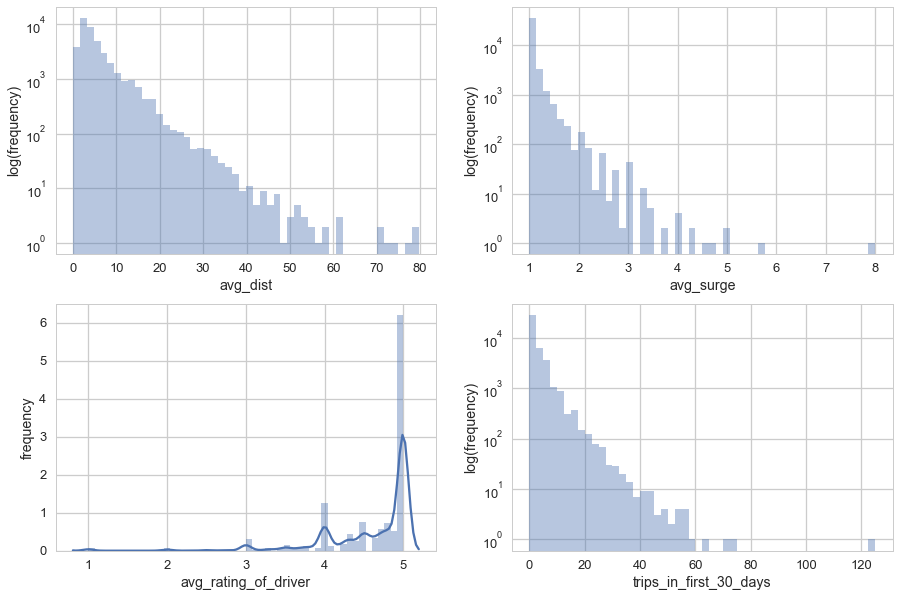

In [28]:
fig, ax=plt.subplots(2,2)
fig.set_size_inches(15,10)

sns.distplot(ultimate_ML.avg_dist, ax=ax[0,0], kde=False)
sns.distplot(ultimate_ML.avg_surge, ax=ax[0,1], kde=False)
sns.distplot(ultimate_ML.avg_rating_of_driver, ax=ax[1,0])
sns.distplot(ultimate_ML.trips_in_first_30_days, ax=ax[1,1], kde=False)

ax[0,0].set_yscale('log')
ax[0,1].set_yscale('log')
ax[1,1].set_yscale('log')

ax[0,0].set_ylabel('log(frequency)')
ax[0,1].set_ylabel('log(frequency)')
ax[1,0].set_ylabel('frequency')
ax[1,1].set_ylabel('log(frequency)')

#### Summary: 
* The proportion of retained customers is 0.37. 
* Average distance, average surge multiplier, and average number of trips in first 30 days are all more freuquently low than high. Most raings of drivers are 4's and 5's. 
* Because of missing driver and passenger ratings 8256 rows were dropped from the original 50,000 row dataframe.

#### 2. Build a predictive model to help Ultimate determine whether or not a user will be active in their 6th month on the system. Discuss why you chose your approach, what alternatives you considered, and any concerns you have. How valid is your model? Include any key indicators of model performance.

In [29]:
# Import scikit-learn tools, grid search cross validation, and classifiers
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import roc_curve
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV

# import Random Forest Classifier
from sklearn.ensemble import RandomForestClassifier

# import Logistic Regression CV Classifier
from sklearn.linear_model import LogisticRegressionCV

from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score, confusion_matrix
from sklearn import decomposition
from sklearn.preprocessing import MinMaxScaler

In [30]:
X = ultimate_ML[['avg_dist', 'avg_rating_by_driver', 'avg_rating_of_driver', 'avg_surge',  'surge_pct', 
                  'trips_in_first_30_days', 'ultimate_black_user', 'weekday_pct', 
                   "city_King's Landing", 'city_Winterfell', 'phone_iPhone']]
y = ultimate_ML.active.values

In [31]:
X.shape

(41744, 11)

In [32]:
# Train Test Split
# split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify=y)

# Show the results of the split
print("X Training set sample size:", (X_train.shape[0]))
print("X Testing set sample size:", (X_test.shape[0]))
print("y Training set sample size:", (y_train.shape[0]))
print("y Testing set sample size:", (y_test.shape[0]))

X Training set sample size: 31308
X Testing set sample size: 10436
y Training set sample size: 31308
y Testing set sample size: 10436


In [33]:
# Double check stratification
print(np.mean(y_train == 0))
print(np.mean(y_test == 0))

0.599271751629
0.599271751629


In [34]:
# Scale continuous variables
# initialize MinMaxScaler
min_max=MinMaxScaler()

# Scale down both train and test data set
X_train_minmax = min_max.fit_transform(X_train[['avg_dist', 'avg_surge',  'surge_pct', 
                  'trips_in_first_30_days', 'weekday_pct']])
X_test_minmax = min_max.fit_transform(X_test[['avg_dist', 'avg_surge',  'surge_pct', 
                  'trips_in_first_30_days', 'weekday_pct']])

###  Classification with LogisticRegressionCV

In [35]:
# Fit Logistic Regression with Cross Validation
lgr=LogisticRegressionCV(scoring='roc_auc').fit(X_train,y_train)
print("training set score: %f" % lgr.score(X_train, y_train))
print('\n'"test set score: %f" % lgr.score(X_test, y_test))

training set score: 0.710394

test set score: 0.710521


In [36]:
# Fit Logistic Regression with Cross Validation: USE SCALED X_train_minmax
lgr=LogisticRegressionCV(scoring='roc_auc').fit(X_train_minmax,y_train)
print("training set score: %f" % lgr.score(X_train_minmax, y_train))
print('\n'"test set score: %f" % lgr.score(X_test_minmax, y_test))

training set score: 0.638623

test set score: 0.624665


#### MinMax Scaler Does not improve prediction

training set score: 0.710394

test set score: 0.710521

Confusion Matrix:
 [[5146 1108]
 [1913 2269]]


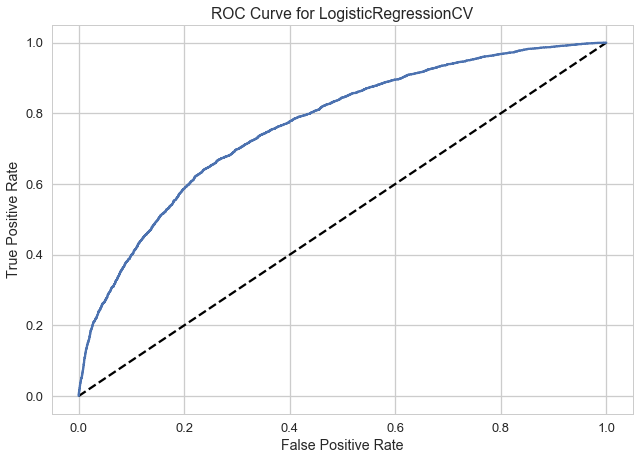


AUC score: 0.76674863047

parameters of current Logistic Regression CV model
 LogisticRegressionCV(Cs=10, class_weight=None, cv=None, dual=False,
           fit_intercept=True, intercept_scaling=1.0, max_iter=100,
           multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
           refit=True, scoring='roc_auc', solver='lbfgs', tol=0.0001,
           verbose=0)


In [37]:
# Fit Logistic Regression with Cross Validation
lgr=LogisticRegressionCV(scoring='roc_auc').fit(X_train,y_train)
print("training set score: %f" % lgr.score(X_train, y_train))
print('\n'"test set score: %f" % lgr.score(X_test, y_test))

# calculated predicted class label per sample: pred_lgr
pred_lgr = lgr.predict(X_test)

# print the confusion matrix 
print('\n''Confusion Matrix:''\n', metrics.confusion_matrix(y_test, pred_lgr))

# calculate predicted probabilities for X_test Logistic Regression model
y_pred_prob_lgr = lgr.predict_proba(X_test)[:, 1]

# Generate ROC curve values: fpr, tpr, thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob_lgr)

# Plot ROC curve
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for LogisticRegressionCV')
plt.show()

# calculate AUC for LogisticRegressionCV classifier
print('\n''AUC score:', metrics.roc_auc_score(y_test, y_pred_prob_lgr))

# view paramaters of logistic regression CV
print('\n''parameters of current Logistic Regression CV model''\n',  lgr)

### Classification with Random Forest Classifier

In [38]:
# Instantiate and fit the random forest model. 
rf = RandomForestClassifier().fit(X_train, y_train) 

## And score it on your testing data.
print("training set score: %f" % rf.score(X_train, y_train))
print('\n'"test set score: %f" % rf.score(X_test, y_test))

training set score: 0.978184

test set score: 0.743484


In [39]:
# Compare to Random Forest fit with scaled min/max X_train
# Instantiate and fit the random forest model. 
rf = RandomForestClassifier().fit(X_train_minmax, y_train) 

## And score it on your testing data.
print("training set score: %f" % rf.score(X_train_minmax, y_train))
print('\n'"test set score: %f" % rf.score(X_test_minmax, y_test))

training set score: 0.936693

test set score: 0.646895



Confusion matrix:
 [[5093 1161]
 [1523 2659]]


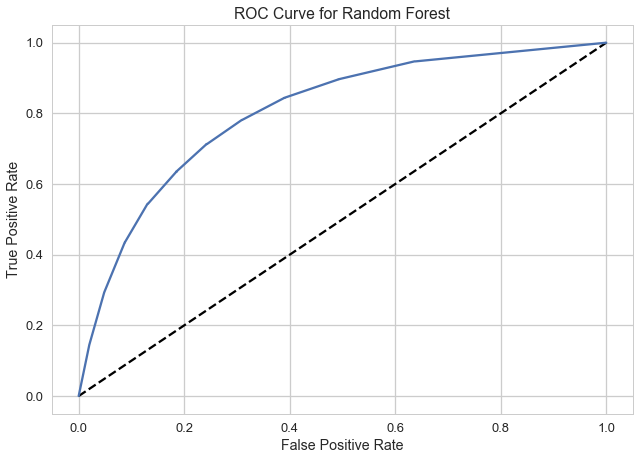

AUC Score for Random Forest Model 0.805008467465


In [40]:
# Re-fit the random forest model to X_train, y_train. 
rf = RandomForestClassifier().fit(X_train, y_train) 

# calculated predicted class label per sample: pred_rf
pred_rf = rf.predict(X_test)

# print the confusion matrix 
print('\n''Confusion matrix:''\n', metrics.confusion_matrix(y_test, pred_rf))

# calculate predicted probabilities
y_pred_prob_rf = rf.predict_proba(X_test)[:, 1]

# Generate ROC curve values: fpr, tpr, thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob_rf)

# Plot ROC curve
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Random Forest')
plt.show()

# calculate AUC for randomforest model
print('AUC Score for Random Forest Model', metrics.roc_auc_score(y_test, y_pred_prob_rf))

In [41]:
# find best parameters with GridSearchCV
# create a list of performace parameters for performace tuning
params = {'max_features': [2,4,6,8],
              'min_samples_leaf': [4, 6, 8, 10],
              'min_samples_split': [3, 7, 8, 10],
         }

In [42]:
# create an instance of the grid search by passing the classifier, parameters 
# and n_jobs=-1 which tells to use multiple cores from user machine.
gs_rf = GridSearchCV(RandomForestClassifier(), params, scoring='roc_auc', n_jobs=-1)
gs_rf = gs_rf.fit(X_train, y_train) 

# View the best AUC score
print('\n''Best score:', gs_rf.best_score_) 

# Get best parameters
print('\n''Best parameters:', gs_rf.best_params_)

# Explore feature importances
feature_importances = pd.DataFrame(rf.feature_importances_,
                                   index = X_train.columns,
                                    columns=['importance']).sort_values('importance', ascending=False)
# Print sorted list of feature importances
feature_importances


Best score: 0.847616530681

Best parameters: {'max_features': 4, 'min_samples_leaf': 10, 'min_samples_split': 10}


,importance
avg_dist,0.267888
weekday_pct,0.136560
avg_rating_by_driver,0.133934
trips_in_first_30_days,0.084616
surge_pct,0.079926
avg_rating_of_driver,0.079323
avg_surge,0.067653
city_King's Landing,0.061282
phone_iPhone,0.040721
ultimate_black_user,0.032312


### Classification with Decision Tree Classifier

In [43]:
treeclf = DecisionTreeClassifier().fit(X_train, y_train)
print("training set score: %f" % treeclf.score(X_train, y_train))
print('\n'"test set score: %f" % treeclf.score(X_test, y_test))

training set score: 0.997668

test set score: 0.698256



Confusion matrix:
 [[4674 1580]
 [1569 2613]]


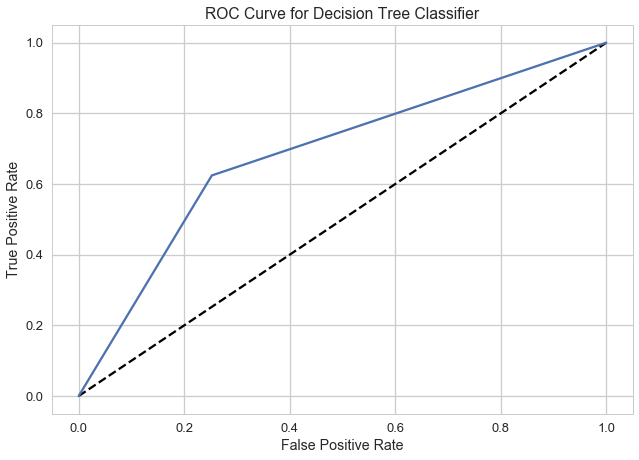

AUC Score for Decision Tree Classifier 0.685938139715


In [44]:
# calculated predicted class label per sample: pred_rf
pred_tree = treeclf.predict(X_test)

# print the confusion matrix 
print('\n''Confusion matrix:''\n', metrics.confusion_matrix(y_test, pred_tree))

# calculate predicted probabilities
y_pred_prob_tree = treeclf.predict_proba(X_test)[:, 1]

# Generate ROC curve values: fpr, tpr, thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob_tree)

# Plot ROC curve
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Decision Tree Classifier')
plt.show()

# calculate AUC for randomforest model
print('AUC Score for Decision Tree Classifier', metrics.roc_auc_score(y_test, y_pred_prob_tree))

In [45]:
# create an instance of the grid search by passing the classifier, parameters 
# and n_jobs=-1 which tells to use multiple cores from user machine.
gs_tree = GridSearchCV(DecisionTreeClassifier(), params, scoring='roc_auc', n_jobs=-1)
gs_tree = gs_tree.fit(X_train, y_train) 

# View the best AUC score
print('\n''Best score:', gs_tree.best_score_) 

# Get best parameters
print('\n''Best parameters:', gs_tree.best_params_)

# Explore feature importances
feature_importances = pd.DataFrame(treeclf.feature_importances_,
                                   index = X_train.columns,
                                    columns=['importance']).sort_values('importance', ascending=False)
# Print sorted list of feature importances
feature_importances


Best score: 0.80964647475

Best parameters: {'max_features': 2, 'min_samples_leaf': 10, 'min_samples_split': 3}


,importance
avg_dist,0.281125
avg_rating_by_driver,0.180665
weekday_pct,0.122257
avg_rating_of_driver,0.077522
surge_pct,0.076791
city_King's Landing,0.069952
trips_in_first_30_days,0.069749
phone_iPhone,0.039188
avg_surge,0.038845
ultimate_black_user,0.026028


### Multinomial Naive Bayes

In [46]:
nbclf = MultinomialNB().fit(X_train, y_train)
print("training set score: %f" % nbclf.score(X_train, y_train))
print('\n'"test set score: %f" % nbclf.score(X_test, y_test))

training set score: 0.652836

test set score: 0.652261



Confusion matrix:
 [[4940 1314]
 [2315 1867]]


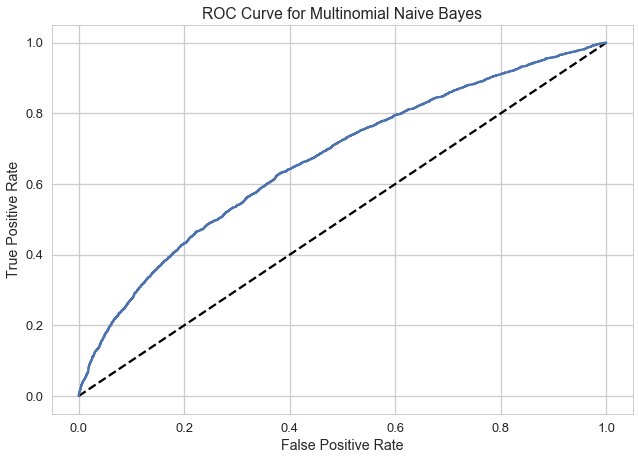

AUC Score for Multinomial Naive Bayes 0.685938139715


In [47]:
# calculated predicted class label per sample: pred_rf
pred_nb = nbclf.predict(X_test)

# print the confusion matrix 
print('\n''Confusion matrix:''\n', metrics.confusion_matrix(y_test, pred_nb))

# calculate predicted probabilities
y_pred_prob_nb = nbclf.predict_proba(X_test)[:, 1]

# Generate ROC curve values: fpr, tpr, thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob_nb)

# Plot ROC curve
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Multinomial Naive Bayes')
plt.show()

# calculate AUC for randomforest model
print('AUC Score for Multinomial Naive Bayes', metrics.roc_auc_score(y_test, y_pred_prob_tree))

#### Reponse:

#### My approach to this problem is a supervised machine learning classification algorithm to predict whether a user in the Ultimate passenger system will be retained as a customer. Retention here is defined as users who are active (use the driver services) in the 6th month after signing up. Since this data set is limited to just one 6-month period and single set of users if it is found to be useful Ultimate should consider collecting user data over a longer period of time. I implemented and compared the following set of classifiers: logistic regression, random forest, decision tree, and multinomial naive bayes. My goal is to effectively classify users in the test data as either active or not active. 

#### I determined that scaling of continuous variables with MinMaxScaler did not improve modeling. Of the four models I compared, Random Forest Classifier preformed best on test data. The model was further improved by using Grid Search Cross Validation to tune hyperparameters. The tuned Random Forest Classifier has an ROC-AUC score of 0.847, higher than the ROC-AUC score for Logistic Regression or Decision Tree. From this ensemble model, the variables with the highest importance values were average distance of trips in the first 30 days,  percentage of trips taken on weekdays, average rating of passenger assigned by driver, and number of trips taken by passenger in the first 30 days after signup. The tuned Decision Tree Classifier also indicates higher importance values for these variables. 

#### 3. Briefly discuss how Ultimate might leverage the insights gained from the model to improve its long-term rider retention (again, a few sentences will suffice).

#### Response

#### Ultimate can use information about influential variables to target marketing to drivers who are more likely to become active: perhaps running weekday ads to communtors, targeting distances associated with returning riders, and increasing frequency of trips in the first month by offering discounts. Creating additional features such as weekday/weekend, Holiday, and night/day rides could increase AUC scores (increase True Positive Rate and decrease False Positive Rate) in future models for Ultimate. With the goal to retain users Ultimate can use influential features from models to attrack specific types of customers.